## BBM 409 - Programming Assignment 2

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Insert personal information (name, surname, student id)

### DOĞUKAN AYTEKİN 2200356003

## 1. Weather Classification for Ankara

### 1.1. Introduction
* Brief overview of the classification task.
* Description of the dataset used for experiment.

### Introduction answers
* In multiclass classification task we have more classes than two to label the data points correctly.

* This dataset is used to classify the weather condition of Ankara using some features.

* Features : Tempmax, Tempmin, Temp , feelslikemax ,feelslikemin , feelslike , dew , humidity , precip , precipprob , precipcover , preciptype , snow , snowdepth , windgust , windspeed , winddir , sealevelpressure , cloudcover , visibility, solarradiation , solarenergy , uvindex , severerisk , moonphase

* Label : weathercondition


### 1.2. Data Loading and Exploration

In [1]:
## Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (c:\Users\dayte\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)

In [ ]:
## Read the regression data and transform it into a Numpy array collection.
## (See pandas and numpy functions)

dfW = pd.read_csv("ankara_weather_condition_dataset.csv", sep=';')

In [ ]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
## Check for any missing values and handle them if necessary.


dfW.isnull().sum()

# Handling categorical missing values, filling them with the most_frequent value in column
impute_mode = SimpleImputer(strategy = 'most_frequent')
impute_mode.fit(dfW[['preciptype']])

dfW[['preciptype']] = impute_mode.transform(dfW[['preciptype']])


In [ ]:
# one hot encode object type columns
dfW = pd.get_dummies(dfW, columns=['preciptype'], prefix = 'P')

dfW['weathercondition'] = dfW['weathercondition'].astype('category').cat.codes


In [ ]:
# Handling numerical missing values, filling them with mean
dfW.isnull().sum()
dfW = dfW.fillna(dfW.mean())

In [ ]:
# changing boolean values to numerical values
dfW = dfW.replace(True, 1)
dfW = dfW.replace(False,0)

# converting datatype of dataframe to float64 all
for col in dfW.columns:
    if dfW[col].dtype == 'int64' or dfW[col].dtype == 'int8' :
        dfW[col] = dfW[col].astype('float64')

# adding weathercondition column to end
column_data = dfW.pop('weathercondition')
dfW.insert(len(dfW.columns), 'weathercondition', column_data)

### 1.3. Data Preprocessing
* Explain the preprocessing steps taken and their rationale.

* I apply chi square and correlation feature selection methods and for feature scaling standardization and normalization techniques are used.

* In dataset we have imbalance in labels and I apply oversampling and undersampling methods to handle.


In [ ]:
## Apply feature selection methods to see if it has a contribution on performance. (ablation study)
## Implement functions for different feature scaling techniques to see their effects on the performance. (ablation study)
## Explain the rationale your choice of methods.


# This function creates different feature selected dataframes by the input
#Feature selection with (correlation-> mode = 0) (chi-square -> mode = 1 )

def FeatureSelection(dfW, mode):
  drop_list = []
  if (mode == 0):
    index=0
    drop_list = []
    for i in dfW.corr()['weathercondition']:
      if abs(i)< 0.3:
        drop_list.append(dfW.columns[index])
      index+=1

  elif (mode==1):
    for column in dfW.columns.tolist():
      cross_tab = pd.crosstab(dfW['weathercondition'], dfW[column])
      chi2, p_value, _, _ = chi2_contingency(cross_tab)
      if(chi2 < 6000):
        drop_list.append(column)

  df2 = dfW.drop(drop_list, axis=1)
  return df2


In [ ]:
# Feature scaling methods

# normalizing
def normalize(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = 2 * ((arr - min_val) / (max_val - min_val)) - 1
    return normalized_arr

# standardizing
def standardize(matrix):
    mean_vals = np.mean(matrix, axis=0)
    std_vals = np.std(matrix, axis=0)
    standardized_matrix = (matrix - mean_vals) / std_vals
    return standardized_matrix

# Creating a scaled matrix by the input
# (ScaleNumber = -1 -> no scaling) , (ScaleNumber = 0 -> normalizing) , (ScaleNumber = 1 -> standardizing)

def FeatureScaling(matrix,scaleNumber):
    colMinusOne = matrix.shape[1]-1
    if(scaleNumber!=-1):
        for i in range(colMinusOne):
            if (scaleNumber==0):
                matrix[:,i]= normalize(matrix[:,i])
            else:
                matrix[:,i]= standardize(matrix[:,i])
    return matrix

In [ ]:
## Handle missing values (if any).
## Split the dataset into training and testing sets.
## Set the training set to be 80% and the test set to be 20% of the dataset.
## Explain the rationale behind the chosen split ratio.

# This function takes dataframe applies feature selection and scaling then splits feature and labels
def ScaleAndSplit(df2,ScalingParameter,SelectionParameter):
  df2 = FeatureSelection(dfW,SelectionParameter)
  df2_matrix = df2.values
  df2_matrix = FeatureScaling(df2_matrix,ScalingParameter)

  label2 = df2_matrix[:,-1]
  feature2 = df2_matrix[:,:df2.shape[1]-1]

  return feature2, label2

* Rationale behind the chosen split ratio : Splitting the training and test datasets into 80-20 ratio provides model to learns effiecently from training data and having enough data to objectively evaluate its generalization ability.

In [ ]:
# This function handles the imbalance of the label values with different techniques
# mode=0 -> UnderSampling mode=1 -> OverSampling
def HandleImbalance(X,Y,mode):
  if mode==0:
    rus = RandomUnderSampler(sampling_strategy='not minority')
    X, Y = rus.fit_resample(X, Y)

  elif mode==1:
    smote = SMOTE(sampling_strategy='auto')
    X, Y = smote.fit_resample(X, Y)

  return X,Y

In [ ]:

# This function takes the dataframe and apply Scale,Split,Handling Imbalances at the end it splits X,Y to train and test
def DfToTrainAndSplit(df2,SamplingParameter,ScalingParameter,SelectionParameter):
  # for scaling (-1 -> no scaling) , (0 -> normalizing) , (1 -> standardizing)
  # for selection 0-> correlation 1-> chi-square selection
  X,Y = ScaleAndSplit(df2,ScalingParameter,SelectionParameter)

  # undersample->0 oversample->1
  X,Y = HandleImbalance(X,Y,SamplingParameter)

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
  return X_train,X_test,Y_train,Y_test


In [ ]:
# sigmoid function to use in logistic regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# softmax function to use in logistic regression
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

### 1.4. Logistic Regression Model
* Implement logistic regression model.
* Explain the reason behind the application of logistic regression on this type of data.

* Logistic regression can be used for multiclass classification, and in this context, the softmax function is employed. The softmax function converts outputs into probabilities, enabling predictions among multiple classes. Given that there are more than two classes to classify in this dataset, it makes sense to use logistic regression.


In [ ]:
# this function creates the y_pred
def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    predictions = softmax(linear_model)
    return np.argmax(predictions, axis=1)

# calculates accuracy
def accuracy_score(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
## Implement logistic regression model from scratch, using libraries like NumPy.

def MulticlassLogisticRegression(X, y, learning_rate=0.01, num_iterations=1000, accuracy_track=False):

    # add accuracy_list if plot the graph
    accuracy_list = []

    # taking necessary sizes
    num_samples, num_features = X.shape
    num_classes = len(np.unique(y))

    #initalize the weight matrix not vector because it is multiclass classification
    weights = np.zeros((num_features, num_classes))
    bias = np.zeros((1, num_classes))

    # One-hot-encode the labels
    y_one_hot = np.eye(num_classes)[y.astype(int)]  # One-hot encoding


    # iterate num_iterations times
    for _ in range(num_iterations):

      # calculate the score
      score = np.dot(X, weights) + bias

      # give score to softmax and take prediction probabilites
      predictions = softmax(score)

      #calculate gradients
      dw = (1 / num_samples) * np.dot(X.T, (predictions - y_one_hot))
      db = (1 / num_samples) * np.sum(predictions - y_one_hot, axis=0)

      #change weight and bias via gradients
      weights -= learning_rate * dw
      bias -= learning_rate * db

      if (accuracy_track):
        y_pred = predict(X, weights, bias)
        accuracy_list.append(accuracy_score(y,y_pred))

    return weights, bias , accuracy_list


In [ ]:
## Train the model using the training dataset.

X_train,X_test,Y_train,Y_test = DfToTrainAndSplit(dfW,SamplingParameter=0 ,ScalingParameter=1 ,SelectionParameter=0)
weights, bias , accuracy_list = MulticlassLogisticRegression(X_train, Y_train, learning_rate=0.1, num_iterations=1000)

In [ ]:
## Evaluate the model's performance on the training set by computing accuracy.

y_pred = predict(X_train, weights, bias)
print("Training accuracy is : " , accuracy_score(Y_train,y_pred))

Training accuracy is :  0.9023569023569024


### 1.5 Model Evaluation on Test Set

In [ ]:
## Make predictions on the test set using the trained model.
## Calculate accuracy for the test set.
## Comment on the scores.

y_pred = predict(X_test, weights, bias)
print("Test accuracy is : " , accuracy_score(Y_test,y_pred))

Test accuracy is :  0.9292929292929293


* I think for the scratch implementation in multiclass problem we have really good accuracy which is 0.94 . In the above cell we can see the accuracy difference of feature selection , scaling and handling imbalance techniques.

Because I create table in above cell it runs approximately in 1.5 minutes

In [ ]:
## Create a table to present the test accuracy for different feature scaling and selection methods.
myTable = PrettyTable(["Sampling Method", "Feature Scaling Method","Accuracy"])


def CalculateAccuracy(df2,SamplingParameter,ScalingParameter,SelectionParameter):
  X_train,X_test,Y_train,Y_test = DfToTrainAndSplit(df2,SamplingParameter,ScalingParameter,SelectionParameter)
  weights, bias, accuracy_list = MulticlassLogisticRegression(X_train, Y_train, learning_rate=0.1, num_iterations=1000)
  y_pred = predict(X_test, weights, bias)
  accuracy = accuracy_score(Y_test,y_pred)
  return accuracy

myTable.add_row(["Undersampling", "Normalization" , CalculateAccuracy(dfW,0,0,1)])
myTable.add_row(["Oversampling", "Normalization", CalculateAccuracy(dfW,1,0,1)])
myTable.add_row(["Undersampling", "Standardization" , CalculateAccuracy(dfW,0,1,1)])
myTable.add_row(["Oversampling", "Standardization", CalculateAccuracy(dfW,1,1,1)])

print("Sampling and Scaling Methods Table")
print(myTable)


Sampling and Scaling Methods Table
+-----------------+------------------------+--------------------+
| Sampling Method | Feature Scaling Method |      Accuracy      |
+-----------------+------------------------+--------------------+
|  Undersampling  |     Normalization      | 0.9057239057239057 |
|   Oversampling  |     Normalization      | 0.908219923788786  |
|  Undersampling  |    Standardization     | 0.9158249158249159 |
|   Oversampling  |    Standardization     | 0.9367446924333152 |
+-----------------+------------------------+--------------------+


* As we can see from table the best sampling method to handle imbalance for this dataset is UnderSampling and best feature scaling method is standardization.

In [ ]:
## Create a table to present the test accuracy for different feature scaling and selection methods.

# Table to see the difference between feature selection methods' effect on accuracy
myTable = PrettyTable(["Feature Selection Method","Accuracy"])

myTable.add_row(["Correlation", CalculateAccuracy(dfW,1,0,0)])
myTable.add_row(["Chi-Square Test", CalculateAccuracy(dfW,1,0,1)])

print("Feature Selection Methods and Accuracy Table")
print(myTable)


Feature Selection Methods and Accuracy Table
+--------------------------+--------------------+
| Feature Selection Method |      Accuracy      |
+--------------------------+--------------------+
|       Correlation        | 0.903320631464344  |
|     Chi-Square Test      | 0.9085465432770822 |
+--------------------------+--------------------+


* We can see from table there is nearly no difference between feature selection methods in accuracy. Also we can change the threshold of them to get different results.

### 1.6 Results Analysis and Conclusion

In the above cell I will train my model with training set then I will test them with test set in different learning rate and iteration parameters.

Because I test with different parameters it will run around 1.5 minutes.

In [ ]:
# train the model with training dataset in different learning rates and iterations, calculate accuracy and append list to calculate the comparison table
myTable_1 = PrettyTable(["Number of Iterations", "Learning Rate","Accuracy"])

learning_rate_list = [0.001,0.01,0.1]
num_iterations = [5000,2000,1000]
for learningRate in learning_rate_list:
  for Iteration in num_iterations:
    weights, bias, accuracy_list = MulticlassLogisticRegression(X_train, Y_train, learning_rate=learningRate, num_iterations=Iteration)
    y_pred = predict(X_test, weights, bias)
    accuracy = accuracy_score(Y_test,y_pred)
    myTable_1.add_row([Iteration, learningRate, accuracy])

print(myTable_1)

+----------------------+---------------+--------------------+
| Number of Iterations | Learning Rate |      Accuracy      |
+----------------------+---------------+--------------------+
|         5000         |     0.001     | 0.835016835016835  |
|         2000         |     0.001     | 0.8181818181818182 |
|         1000         |     0.001     | 0.8148148148148148 |
|         5000         |      0.01     | 0.9326599326599326 |
|         2000         |      0.01     | 0.9124579124579124 |
|         1000         |      0.01     | 0.8585858585858586 |
|         5000         |      0.1      | 0.9494949494949495 |
|         2000         |      0.1      | 0.9461279461279462 |
|         1000         |      0.1      | 0.9292929292929293 |
+----------------------+---------------+--------------------+


* We can see that number of iteration and learning rate hyperparameters can change accuracy very much. We have to choose number of iterations 5000 , learning rate 0.1 to get best result.


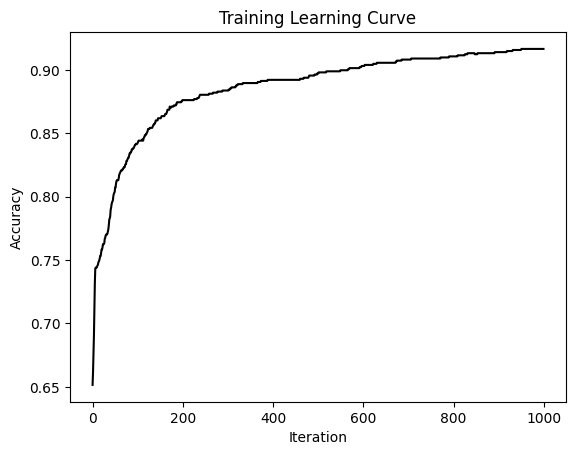

In [ ]:
## Plot training accuracys to visualize the learning curve.
## Interpret the results of the ablation study on feature scaling and selection.
## Discuss the impact of feature scaling on model performance.
## Summarize key findings from the logistic regression analysis.

X_train,X_test,Y_train,Y_test = DfToTrainAndSplit(dfW,SamplingParameter=0 ,ScalingParameter=1 ,SelectionParameter=0)
weights, bias , accuracy_list = MulticlassLogisticRegression(X_train, Y_train, learning_rate=0.1, num_iterations=1000,accuracy_track=True)

index_list = []
for i in range(len(accuracy_list)):
    index_list.append(i)

plt.title("Training Learning Curve")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.plot(index_list,accuracy_list, color="black")
plt.show()


* To summarize:
  For this type of dataset logistic regression works best when we choose number of iterations 5000 , learning rate 0.1 . Accuracy is really good for a scratch implementation. I think for this dataset it runs faster for multiple classification.

* If we look at the graph in some points we have very little decrease in accuracy it can be because of learning rate is 0.1 . If we choose it smaller this decreases won't be there

## 2. DDoS Attack Classification

### 2.1. Introduction
* Brief overview of the classification task.
* Description of the dataset used for classification analysis.

### Introduction answers
* In this classification task we are trying to predict the ddos attack from conditions that comes from features.

* For this task we have binary classification problem differs than first one.

* For this task we have bigger task it has nearly 100000 samples.

* Features : dt, switch, src, dst, pktcount, bytecount, dur,dur_nsec, tot_dur, flows, packetins, pktperflow, byteperflow, pktrate, Pairflow, Protocol,port_no,
 tx_bytes, rx_bytes, tx_kbps, rx_kbps, tot_kbps

 Label : label (if label equals one it is ddos attack if equals zero it is not)

### 2.2. Data Loading and Exploration

In [ ]:
## Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt



In [ ]:
## Read the classification data and transform it into a Numpy array collection.
## (See pandas and numpy functions)
df = pd.read_csv("ddos_dataset.csv")
data_matrix = df.values
df

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103434,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
103435,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
103436,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
103437,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


In [ ]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
## Check for any missing values and handle them if necessary.

# not any NaN values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103439 entries, 0 to 103438
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           103439 non-null  int64  
 1   switch       103439 non-null  int64  
 2   src          103439 non-null  object 
 3   dst          103439 non-null  object 
 4   pktcount     103439 non-null  int64  
 5   bytecount    103439 non-null  int64  
 6   dur          103439 non-null  int64  
 7   dur_nsec     103439 non-null  int64  
 8   tot_dur      103439 non-null  float64
 9   flows        103439 non-null  int64  
 10  packetins    103439 non-null  int64  
 11  pktperflow   103439 non-null  int64  
 12  byteperflow  103439 non-null  int64  
 13  pktrate      103439 non-null  int64  
 14  Pairflow     103439 non-null  int64  
 15  Protocol     103439 non-null  object 
 16  port_no      103439 non-null  int64  
 17  tx_bytes     103439 non-null  int64  
 18  rx_bytes     103439 non-

### 2.3. Data Preprocessing
* Explain the preprocessing steps taken and their rationale.

* For this binary classification task I apply same different methods with multiclass one to compare the accuracy results.

* I apply chi square and correlation feature selection methods and for feature scaling standardization and normalization techniques are used.

* In dataset we have imbalance in labels and I apply oversampling and undersampling methods to handle.


In [ ]:
df = pd.get_dummies(df, columns=['Protocol'], prefix = 'P')
df  = df.drop(['src' , 'dst'] , axis = 1)

In [ ]:
df.info()
df = df.astype('float64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103439 entries, 0 to 103438
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           103439 non-null  int64  
 1   switch       103439 non-null  int64  
 2   pktcount     103439 non-null  int64  
 3   bytecount    103439 non-null  int64  
 4   dur          103439 non-null  int64  
 5   dur_nsec     103439 non-null  int64  
 6   tot_dur      103439 non-null  float64
 7   flows        103439 non-null  int64  
 8   packetins    103439 non-null  int64  
 9   pktperflow   103439 non-null  int64  
 10  byteperflow  103439 non-null  int64  
 11  pktrate      103439 non-null  int64  
 12  Pairflow     103439 non-null  int64  
 13  port_no      103439 non-null  int64  
 14  tx_bytes     103439 non-null  int64  
 15  rx_bytes     103439 non-null  int64  
 16  tx_kbps      103439 non-null  int64  
 17  rx_kbps      103439 non-null  float64
 18  tot_kbps     103439 non-

In [ ]:
# change boolean values to numerical values
df = df.replace(True, 1)
df = df.replace(False,0)

# make label the last column
column_data = df.pop('label')
df.insert(len(df.columns), 'label', column_data)

In [ ]:
# Feature scaling methods

# normalizing
def normalize(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = 2 * ((arr - min_val) / (max_val - min_val)) - 1
    return normalized_arr

# standardizing
def standardize(matrix):
    mean_vals = np.mean(matrix, axis=0)
    std_vals = np.std(matrix, axis=0)
    standardized_matrix = (matrix - mean_vals) / std_vals
    return standardized_matrix

# Creating a scaled matrix by the input
# (ScaleNumber = -1 -> no scaling) , (ScaleNumber = 0 -> normalizing) , (ScaleNumber = 1 -> standardizing)

def FeatureScaling(matrix,scaleNumber):
    colMinusOne = matrix.shape[1]-1
    if(scaleNumber!=-1):
        for i in range(colMinusOne):
            if (scaleNumber==0):
                matrix[:,i]= normalize(matrix[:,i])
            else:
                matrix[:,i]= standardize(matrix[:,i])
    return matrix

In [ ]:
# This function handles the imbalance of the label values with different techniques
# mode=0 -> UnderSampling mode=1 -> OverSampling
def HandleImbalance(X,Y,mode):
  if mode==0:
    rus = RandomUnderSampler(sampling_strategy='not minority')
    X, Y = rus.fit_resample(X, Y)

  elif mode==1:
    smote = SMOTE(sampling_strategy='auto')
    X, Y = smote.fit_resample(X, Y)

  return X,Y

In [ ]:
# apply feature selection
def FeatureSelection(df, mode):
  drop_list = []
  if (mode == 0):
    index=0
    drop_list = []
    for i in df.corr()['label']:
      if abs(i)< 0.2:
        drop_list.append(df.columns[index])
      index+=1

  elif (mode==1):
    for column in df.columns.tolist():
      cross_tab = pd.crosstab(df['label'], df[column])
      chi2, p_value, _, _ = chi2_contingency(cross_tab)
      if(chi2 < 6000):
        drop_list.append(column)

  df2 = df.drop(drop_list, axis=1)

  return df2

In [ ]:
# apply feature selection and scaling methods take feature and label matrixes
def ScaleAndSplit(df2,ScalingParameter,SelectionParameter):
  df2 = FeatureSelection(df,SelectionParameter)
  df2_matrix = df2.values
  df2_matrix = FeatureScaling(df2_matrix,ScalingParameter)

  label2 = df2_matrix[:,-1]
  feature2 = df2_matrix[:,:df2.shape[1]-1]

  return feature2, label2

In [ ]:
# This function takes the dataframe and apply Scale,Split,Handling Imbalances at the end it splits X,Y to train and test

def DfToTrainAndSplit(df2,SamplingParameter,ScalingParameter,SelectionParameter):
  # for scaling (-1 -> no scaling) , (0 -> normalizing) , (1 -> standardizing)
  # for selection 0-> correlation 1-> chi-square selection
  X,Y = ScaleAndSplit(df2,ScalingParameter,SelectionParameter)

  # undersample->0 oversample->1
  X,Y = HandleImbalance(X,Y,SamplingParameter)

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

  X_train = X_train.T
  Y_train = Y_train.reshape(1, X_train.shape[1])

  X_test = X_test.T
  Y_test = Y_test.reshape(1, X_test.shape[1])

  return X_train,X_test,Y_train,Y_test


In [ ]:
## Handle missing values (if any).
## Split the dataset into training and testing sets. (80% train, 20% test)

X_train,X_test,Y_train,Y_test = DfToTrainAndSplit(df,0,1,1)

* Rationale behind the chosen split ratio : Splitting the training and test datasets into 80-20 ratio provides model to learns effiecently from training data and having enough data to objectively evaluate its generalization ability.

### 2.4. Logistic Regression Model
* Implement logistic regression model.
* Explain the reason behind the application of logistic regression on this type of data.

In [ ]:
# sigmoid function to use in logistic regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
## Implement logistic regression model from scratch, using libraries like NumPy.

def BinaryLogisticRegression(X,Y , LearningRate , iteration, accuracy_track = False):
    accuracy_list = []
    m = np.shape(X)[1]
    number_of_weights = np.shape(X)[0]
    weights = np.zeros((number_of_weights,1))
    Bias = 0

    for i in range(iteration):
        score = np.dot(weights.T,X) + Bias
        prob = sigmoid(score)

        dW = (1/m) * np.dot(prob-Y, X.T)
        dB = (1/m) * np.sum(prob - Y)

        weights = weights - LearningRate * dW.T
        Bias = Bias - LearningRate * dB

        if (accuracy_track):
          score_pred = np.dot(weights.T,X) + Bias
          prob_pred = sigmoid(score_pred)
          y_pred = (prob_pred > 0.5).astype(int)
          accuracy_list.append((1-np.sum(np.absolute(y_pred-Y))/Y.shape[1]))

    return weights , Bias , accuracy_list

In [ ]:
## Train the model using the training dataset.
iterations = 1000
learning_rate = 0.1
weight , bias , accuracy_list_binary= BinaryLogisticRegression(X_train,Y_train,learning_rate,iterations,accuracy_track=True)

In [ ]:
## Evaluate the model's performance on the training set by computing accuracy.

score_pred = np.dot(weight.T,X_train) + bias
prob_pred = sigmoid(score_pred)
prob_pred[prob_pred > 0.5] = np.float64(1)
prob_pred[prob_pred <= 0.5] = np.float64(0)
print("Training accuracy is : " ,(1-np.sum(np.absolute(prob_pred-Y_train))/Y_train.shape[1]))


Training accuracy is :  0.7529076078528673


### 2.5. Model Evaluation on Test Set

In [ ]:
## Make predictions on the test set using the trained model.
## Calculate accuracy for the test set.
## Comment on the scores.

score_pred = np.dot(weight.T,X_test) + bias
prob_pred = sigmoid(score_pred)
y_pred = (prob_pred > 0.5).astype(int)
print("Test accuracy is : " ,(1-np.sum(np.absolute(y_pred-Y_test))/Y_test.shape[1]))

Test accuracy is :  0.7574742587768267


* I do not expect that I will get lower accuracy in the binary classification than multiclass one in begining of the assignment but when I ask it from piazza I learn that it is in good range of accuracy. I think it cause because of the dataset.

In [ ]:
def CalculateAccuracy1(df2,SamplingParameter,ScalingParameter,SelectionParameter):
  X_train,X_test,Y_train,Y_test = DfToTrainAndSplit(df2,SamplingParameter,ScalingParameter,SelectionParameter)
  weight, bias, _ = BinaryLogisticRegression(X_train, Y_train, 0.1, 1000)

  score_pred = np.dot(weight.T,X_test) + bias
  prob_pred = sigmoid(score_pred)
  y_pred = (prob_pred > 0.5).astype(int)
  accuracy = (1-np.sum(np.absolute(y_pred-Y_test))/Y_test.shape[1])

  return accuracy

In [ ]:
## Create a table to present the test accuracy for different feature scaling and selection methods.

For the 3 table creating cell above this markdown will be run approximately 1.5 minutes because I train the model more than one times.

In [ ]:
# train the model with training dataset in different learning rates and iterations, calculate accuracy and append list to calculate the comparison table
myTable_1 = PrettyTable(["Number of Iterations", "Learning Rate","Accuracy"])

learning_rate_list = [0.001,0.01,0.1]
num_iterations = [5000,2000,1000]
for learningRate in learning_rate_list:
  for Iteration in num_iterations:
    myTable_1.add_row([Iteration, learningRate, CalculateAccuracy1(df,0,1,1)])

print(myTable_1)

+----------------------+---------------+--------------------+
| Number of Iterations | Learning Rate |      Accuracy      |
+----------------------+---------------+--------------------+
|         5000         |     0.001     | 0.7533184468428235 |
|         2000         |     0.001     | 0.7547450688500186 |
|         1000         |     0.001     | 0.7560476367696316 |
|         5000         |      0.01     | 0.758342637389902  |
|         2000         |      0.01     | 0.7571020965140801 |
|         1000         |      0.01     | 0.7551172311127652 |
|         5000         |      0.1      | 0.754310879543481  |
|         2000         |      0.1      | 0.7562337179010048 |
|         1000         |      0.1      | 0.7536906091055701 |
+----------------------+---------------+--------------------+


* We can see that effect of number of iterations and learning rate change is lower than multiclass one because the accuracy results are very similar.

In [ ]:
## Create a table to present the test accuracy for different feature scaling and selection methods.
myTable = PrettyTable(["Sampling Method", "Feature Scaling Method","Accuracy"])

myTable.add_row(["Undersampling", "Normalization" , CalculateAccuracy1(df,0,0,1)])
myTable.add_row(["Oversampling", "Normalization", CalculateAccuracy1(df,1,0,1)])
myTable.add_row(["Undersampling", "Standardization" , CalculateAccuracy1(df,0,1,1)])
myTable.add_row(["Oversampling", "Standardization", CalculateAccuracy1(df,1,1,1)])

print("Sampling and Scaling Methods Table")
print(myTable)


Sampling and Scaling Methods Table
+-----------------+------------------------+--------------------+
| Sampling Method | Feature Scaling Method |      Accuracy      |
+-----------------+------------------------+--------------------+
|  Undersampling  |     Normalization      | 0.6736757226150601 |
|   Oversampling  |     Normalization      | 0.6756949394155382 |
|  Undersampling  |    Standardization     | 0.7589008807840218 |
|   Oversampling  |    Standardization     | 0.7542567514057179 |
+-----------------+------------------------+--------------------+


* We can see that in this dataset main game changer is the feature scaling method change. Because the effect of sampling method and feature selecting method effect (table is in the above cell) very smaller compare to scaling. If we want to take the best accuracy we have to make feature scaling method as standardization.

In [ ]:
# Table to see the difference between feature selection methods' effect on accuracy
myTable = PrettyTable(["Feature Selection Method","Accuracy"])

myTable.add_row(["Correlation", CalculateAccuracy1(df,1,0,0)])
myTable.add_row(["Chi-Square Test", CalculateAccuracy1(df,1,0,1)])

print("Feature Selection Methods and Accuracy Table")
print(myTable)


Feature Selection Methods and Accuracy Table
+--------------------------+--------------------+
| Feature Selection Method |      Accuracy      |
+--------------------------+--------------------+
|       Correlation        | 0.6478973627940128 |
|     Chi-Square Test      | 0.6756553417280431 |
+--------------------------+--------------------+


* Very small difference between the selection methods.

### 2.6 Results Analysis and Conclusion

In [ ]:
## Plot training accuracys to visualize the learning curve.
## Interpret the results of the ablation study on feature scaling and selection.
## Discuss the impact of feature scaling on model performance.
## Summarize key findings from the logistic regression analysis.

* For first three task I did them in the previous cells.

* For the last summarizing one:
  For this type of dataset logistic regression works best when we choose feature scaling method standardazing and feature selection method Chi-Square Test. Accuracy is not bad for this type of dataset. Also I want to add that when we make correlation it runs faster than the chi-square one.


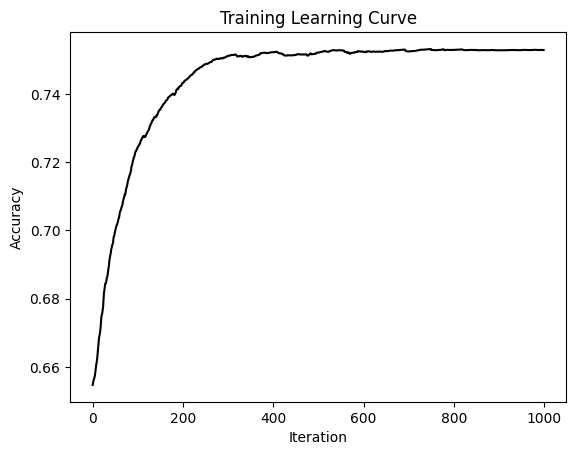

In [ ]:
index_list = []
for i in range(len(accuracy_list_binary)):
    index_list.append(i)

plt.title("Training Learning Curve")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.plot(index_list,accuracy_list_binary, color="black")
plt.show()


* Just like in multiclass graph this small decrase in accuracy parts are there because of the learning rate is higher than it have to be.










### Thank you for reading my code and report. I hope you like my Assignment.